# A Wine Quality Prediction Experiment with SKLearn Pipelines

In this experiment, let us use the [Wine Quality Dataset from Kaggle](https://www.kaggle.com/datasets/yasserh/wine-quality-dataset/data) to predict the quality of wine based on its features. We will investigate the dataset, use [SKLearn](https://scikit-learn.org/stable/) pipelines to preprocess the data, and to evaluate the performance of different models towards finding a suitable regressor. This is a normal activity in any machine learning project.

## Loading the data

Let us start by loading the data into a Pandas dataframe. Remember that a Dataframe is a 2-dimensional labeled data structure with columns of potentially different types. You can think of it like a spreadsheet or SQL table, or a dictionary of Series objects.

In [37]:
# Read in '.data/WineQT.csv' as a pandas dataframe

import pandas as pd

wine = pd.read_csv('.data/WineQT.csv')


Let us look at a few data examples.

In [38]:
wine

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,0
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,1
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,2
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,3
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1138,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6,1592
1139,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5,6,1593
1140,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5,1594
1141,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6,1595


We can see the dataset is composed of 1143 samples, with 13 columns in total. Let us check the various datatypes in the dataset, and ensure there are no missing values.

In [39]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1143 non-null   float64
 1   volatile acidity      1143 non-null   float64
 2   citric acid           1143 non-null   float64
 3   residual sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free sulfur dioxide   1143 non-null   float64
 6   total sulfur dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   pH                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
 12  Id                    1143 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 116.2 KB


We don't particularly care about the `Id` column, so let us drop it from the dataset.

In [40]:
wine.drop('Id', inplace=True, axis=1)

Let us further describe the dataset to understand the distribution of the data.

In [41]:
wine.describe().drop('count').style.background_gradient(cmap='Greens')

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
mean,8.311111,0.531339,0.268364,2.532152,0.086933,15.615486,45.914698,0.996730,3.311015,0.657708,10.442111,5.657043
std,1.747595,0.179633,0.196686,1.355917,0.047267,10.250486,32.782130,0.001925,0.156664,0.170399,1.082196,0.805824
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.392500,0.090000,1.900000,0.070000,7.000000,21.000000,0.995570,3.205000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.250000,2.200000,0.079000,13.000000,37.000000,0.996680,3.310000,0.620000,10.200000,6.000000
75%,9.100000,0.640000,0.420000,2.600000,0.090000,21.000000,61.000000,0.997845,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,68.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


And let's visually inspect the distribution of the data.

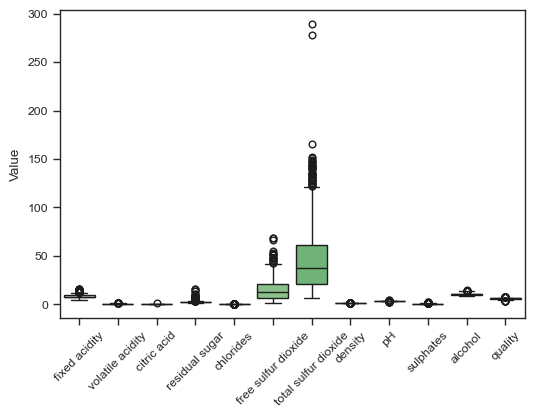

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
plt.figure(figsize=(6, 4))
sns.boxplot(data=wine, palette="Greens")  # This applies the green palette directly

plt.xticks(rotation=45)  # Rotate x-tick labels for better readability
plt.ylabel('Value')
plt.show()


Notice above how 'total sulfur dioxide' and 'free sulfur dioxide' have a very different scale compared to the other features.

<div class="alert alert-block alert-info">
<b>Note: </b>
An important step in preprocessing the data is to scale the features. This is because the features are in different scales, and this can affect the performance of the model. We will use a MinMaxScaler() to scale the features when defining the pipeline for our processing, as MinMaxScaler() scales the data to a fixed range [0, 1] and helps in preserving the shape of the original distribution (while being more sensitive to outliers).
</div>


Our target variable is the 'quality' column, let us look at its distribution more carefully.

In [43]:
# Show the distribution of 'quality'

pd.DataFrame(wine['quality'].value_counts())

,count
quality,
5,483
6,462
7,143
4,33
8,16
3,6


We can see the majority of wines have a quality of 5 or 6, with only very few wines having a quality of 3 or 4. Let us see this as a histogram of the quality column.

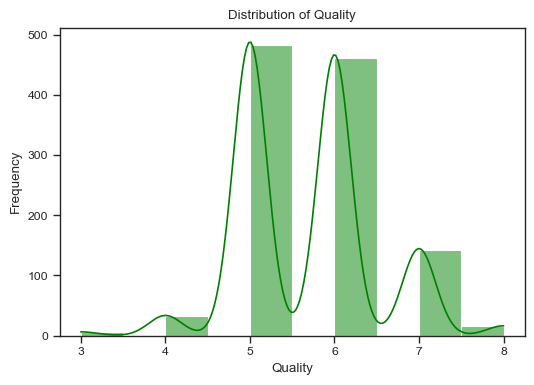

In [44]:
# Show the distribution of 'quality' as a histogram using Seaborne.

plt.figure(figsize=(6, 4))
sns.histplot(data=wine, x='quality', bins=10, kde=True, color='green')

plt.xlabel('Quality')
plt.ylabel('Frequency')
plt.title('Distribution of Quality')
plt.show()

Let us now look at the correlation of the features with the target variable. Let us also drop all columns with a correlation of less than 0.2 with the target variable - this will help us reduce the number of features in our model, and help the model generalize better by focusing on the most important features.

<div class="alert alert-block alert-info">
<b>Note: </b>
In many cases, it is important to reduce the number of features in the model. This is because having too many features can lead to overfitting, and the model may not generalize well to new data. In this case, we are dropping features with a correlation of less than 0.2 with the target variable, as they are less likely to be important in predicting the quality of wine.
</div>

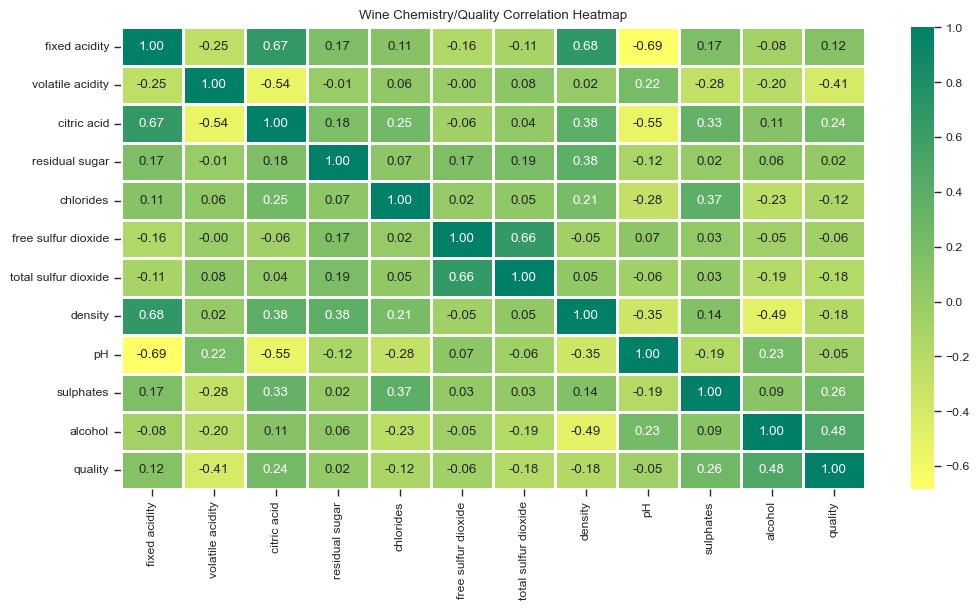

In [45]:
# plot a correlation chart of the features against the 'quality' target variable.

import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the correlation matrix
correlation_matrix = wine.corr()

# Identify features with correlation to 'quality' less than 0.2
# Use absolute value to consider both positive and negative correlations
features_to_keep = correlation_matrix.index[abs(correlation_matrix["quality"]) >= 0.2]

plt.figure(figsize=(12,6))
sns.heatmap(correlation_matrix,
            annot=True,
            cmap='summer_r',
            fmt='.2f',
            linewidths=2).set_title("Wine Chemistry/Quality Correlation Heatmap")
plt.show()

# Keep these features in the DataFrame, including the target variable 'quality'
wine = wine[features_to_keep]

From this correlation matrix it becomes apparent that `alcohol`, `sulphates`, `volatile acidity` and `citric acid` are the features with the highest correlation with the target variable.

Now let us plot a matrix for the features to see how they are related to each other. This will help us understand the multicollinearity between the features, as effectively a chemical feature comparison. Notice how we now have a smaller number of features, as we dropped the ones with a correlation of less than 0.2 with the target variable.

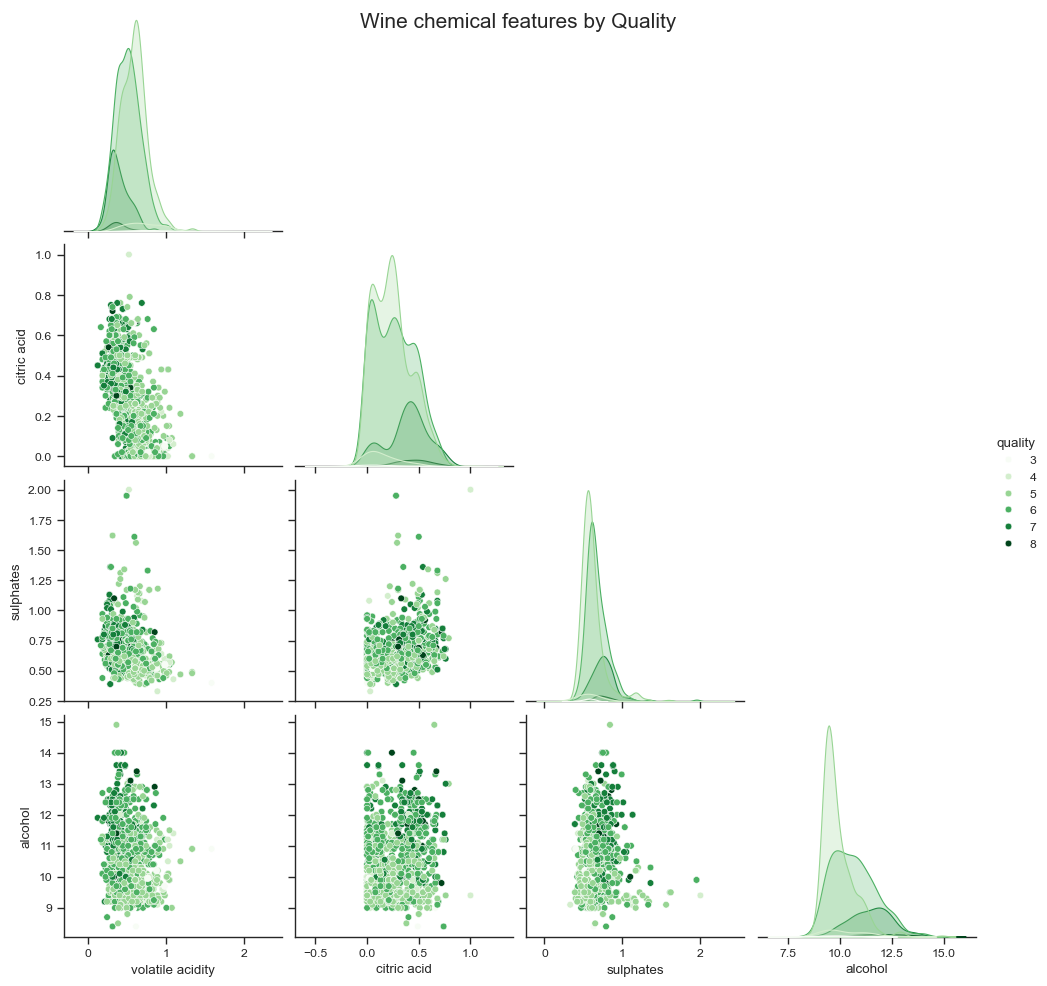

,volatile acidity,citric acid,sulphates,alcohol,quality
0,0.700,0.00,0.56,9.4,5
1,0.880,0.00,0.68,9.8,5
2,0.760,0.04,0.65,9.8,5
3,0.280,0.56,0.58,9.8,6
4,0.700,0.00,0.56,9.4,5
...,...,...,...,...,...
1138,0.510,0.13,0.75,11.0,6
1139,0.620,0.08,0.82,9.5,6
1140,0.600,0.08,0.58,10.5,5
1141,0.550,0.10,0.76,11.2,6


In [46]:
# Now let us chart a matrix of plots, with X vs Y between all features.
# This will effectively give us a chemical composition matrix, where the color of the plot will indicate the quality.

# Pair plot using seaborn
sns.set_theme(context="paper", style="ticks")  # Set the style of the visualization
pairplot = sns.pairplot(wine, hue="quality", palette="Greens", corner=True)

pairplot.figure.suptitle("Wine chemical features by Quality", size=15)
plt.show()

wine



Now let us derive a second dataset, grouped by quality, where each featured is averaged. We will then use this to plot an aggregate positioning of the best correlated features.

In [47]:
wine_grouped_by_quality = wine.groupby('quality').mean()
wine_grouped_by_quality.reset_index(inplace=True)

And now let us plot the positioning for the three best correlators.

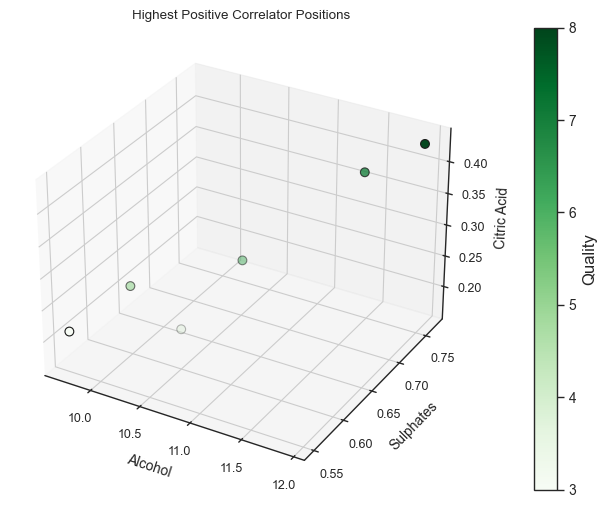

In [48]:

fig = plt.figure(figsize=(8, 6))  # Adjusting figure size
ax = fig.add_subplot(111, projection='3d')

# Normalize 'quality' values for color mapping
norm = plt.Normalize(wine_grouped_by_quality['quality'].min(), wine_grouped_by_quality['quality'].max())
colors = plt.get_cmap('Greens')(norm(wine_grouped_by_quality['quality']))

# 3D scatter plot
sc = ax.scatter(wine_grouped_by_quality['alcohol'], 
                wine_grouped_by_quality['sulphates'], 
                wine_grouped_by_quality['citric acid'], 
                c=colors, edgecolor='k', s=40, depthshade=True)

# Create a color bar with the correct mapping
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='Greens'), ax=ax, pad=0.1)
cbar.set_label('Quality', fontsize=12)
# Set font size for the color bar tick labels
cbar.ax.tick_params(labelsize=10)  # Adjust labelsize as needed

# Labels and title
ax.set_xlabel('Alcohol', fontsize=10)
ax.set_ylabel('Sulphates', fontsize=10)
ax.set_zlabel('Citric Acid', fontsize=10)
ax.set_title('Highest Positive Correlator Positions')

# Set font size for the tick labels on all axes
ax.tick_params(axis='both', which='major', labelsize=9)
ax.tick_params(axis='both', which='minor', labelsize=8)

plt.show()



## Evaluating different models

Let us now evaluate different models to predict the quality of the wine. We will use a pipeline to preprocess the data, and then evaluate the performance of different models. We will use the following models:

- **Linear Regression**: A simple echnique for regression that assumes a linear relationship between the input variables (features) and the single output variable (quality). It is often used as a baseline for regression tasks.
- **Random Forest Regressor**: An ensemble method that operates by constructing multiple decision trees during training time and outputting the average prediction of the individual trees. It is robust against overfitting and is often effective for a wide range of regression tasks.
- **SVR (Support Vector Regression)**: An extension of Support Vector Machines (SVM) to regression problems. SVR can efficiently perform linear and non-linear regression, capturing complex relationships between the features and the target variable.
- **XGBoost Regressor**: A highly efficient and scalable implementation of gradient boosting framework. XGBoost is known for its speed and performance, and it has become a popular choice in data science competitions for its ability to handle sparse data and its efficiency in training.
- **KNeighbors Regressor**: A type of instance-based learning or non-generalizing learning that does not attempt to construct a general internal model, but stores instances of the training data. Classification is computed from a simple majority vote of the nearest neighbors of each point.

For each model, we will scale the features using `MinMaxScaler` to ensure that all features contribute equally to the result. This is particularly important for models like SVR and KNeighbors Regressor, which are sensitive to the scale of the input features. We will then perform hyperparameter tuning to find the best parameters for each model, using `GridSearchCV` to systematically explore a range of parameters for each model. Finally, we will evaluate the performance of each model based on the negative mean squared error (`neg_mean_squared_error`), allowing us to identify the model that best predicts the quality of the wine.


Best regressor: KNeighbors with neg_mean_squared_error score: -0.38768439914783254, MSE: 0.38768439914783254, and parameters: {'KNeighbors__n_neighbors': 9, 'KNeighbors__weights': 'distance'}


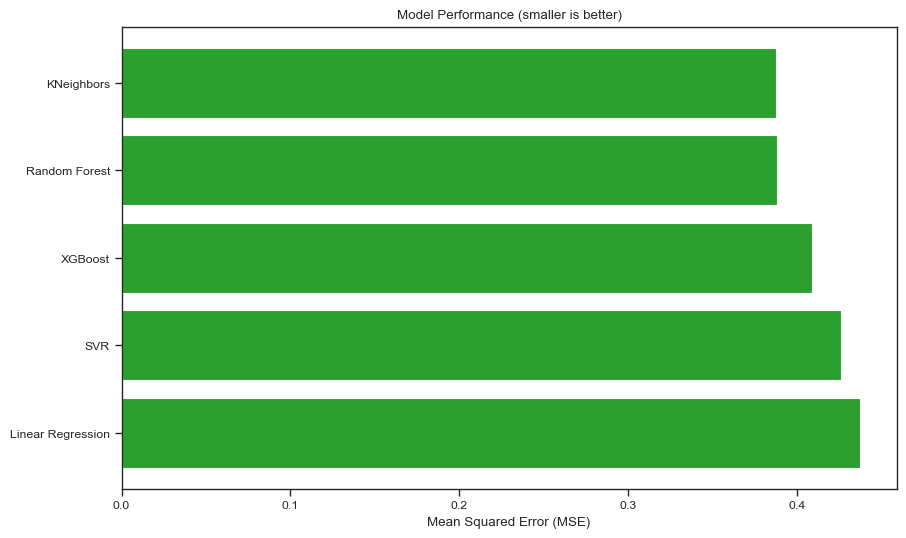

In [49]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
import numpy as np

# Split 'wine' into features (X, all columns except quality) and target (y, only quality)
X = wine.drop('quality', axis=1)
y = wine['quality']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models and their respective parameter grids. Note that the parameter grid keys must be prefixed by the model name in the pipeline.
models_params = [
    ('Linear Regression', LinearRegression(), {}),
    ('Random Forest', RandomForestRegressor(), {
        'Random Forest__n_estimators': [10, 100, 200],
        'Random Forest__max_depth': [None, 10, 20, 30],
    }),
    ('SVR', SVR(), {
        'SVR__C': [0.1, 1, 10],
        'SVR__kernel': ['linear', 'rbf'],
    }),
    ('XGBoost', XGBRegressor(), {
        'XGBoost__n_estimators': [100, 200, 400, 800],
        'XGBoost__learning_rate': [0.005, 0.01, 0.1, 0.2],
        'XGBoost__max_depth': [3, 5, 7, 9],
        'XGBoost__seed': [42],
    }),
    ('KNeighbors', KNeighborsRegressor(), {
        'KNeighbors__n_neighbors': [3, 5, 7, 9],
        'KNeighbors__weights': ['uniform', 'distance'],
    })
]

best_score = float('-inf')
best_regressor = None
best_params = None
model_names = []
scores = []

for name, regressor, params in models_params:
    pipeline = Pipeline([
        ('scaler', MinMaxScaler()),  # Scale features
        (name, regressor)  # Use the model name as the step name in the pipeline
    ])
    
    if params:
        # Perform hyperparameter tuning for models with a defined parameter grid
        grid_search = GridSearchCV(pipeline, param_grid=params, cv=5, scoring='neg_mean_squared_error')
        grid_search.fit(X_train, y_train)
        score = grid_search.best_score_
        params = grid_search.best_params_
    else:
        # For simplicity, directly evaluate models without a parameter grid
        score = np.mean(cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))
    
    # Store the model name and score
    model_names.append(name)
    scores.append(score)

    if score > best_score:
        best_score = score
        best_regressor = name
        best_params = params

# Calculate MSE by negating the best_score
mse = best_score * -1

print(f"Best regressor: {best_regressor} with neg_mean_squared_error score: {best_score}, MSE: {mse}, and parameters: {best_params}")

# Pair each model name with its score, sort by score, and then unzip back into separate lists
sorted_pairs = sorted(zip(scores, model_names), key=lambda x: x[0])

# Unzipping the sorted pairs
sorted_scores, sorted_model_names = zip(*sorted_pairs)

# Plotting the performance of each model with sorted values
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(sorted_model_names, [score * -1 for score in sorted_scores], color='#2CA02C')
ax.set_xlabel('Mean Squared Error (MSE)')
ax.set_title('Model Performance (smaller is better)')

plt.show()

That's great! We now know the best performing model!

Now let us run some actual predictions with the best performing model, and plot residuals.

<div class="alert alert-block alert-info">
<b>Note: </b>
Residuals are the difference between the observed values and the predicted values. By plotting the residuals, we can visually inspect the performance of the model. Ideally, the residuals should be randomly distributed around zero, indicating that the model is making predictions without any systematic errors. If we observe a pattern in the residuals, it may indicate that the model is not capturing some underlying patterns in the data.
</div>

Test MSE for the best regressor (KNeighbors): 0.3381499055639954
Residuals Summary Statistics:
count    229.000000
mean      -0.048154
std        0.580779
min       -2.233049
25%       -0.351151
50%        0.000000
75%        0.241689
max        1.923910
Name: quality, dtype: float64


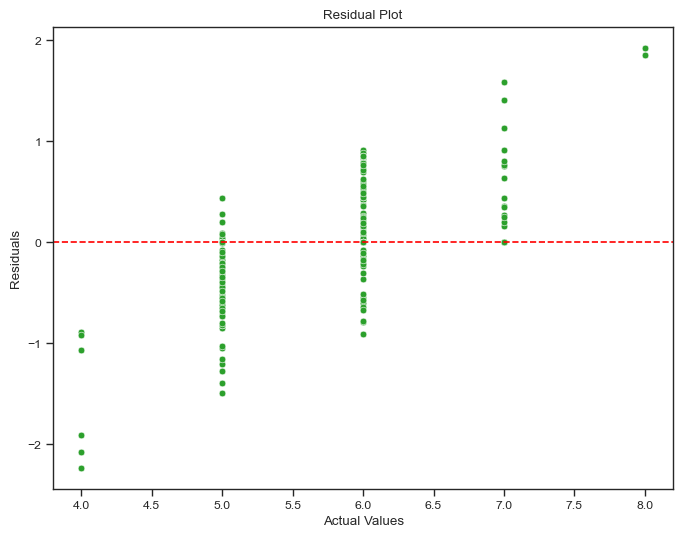

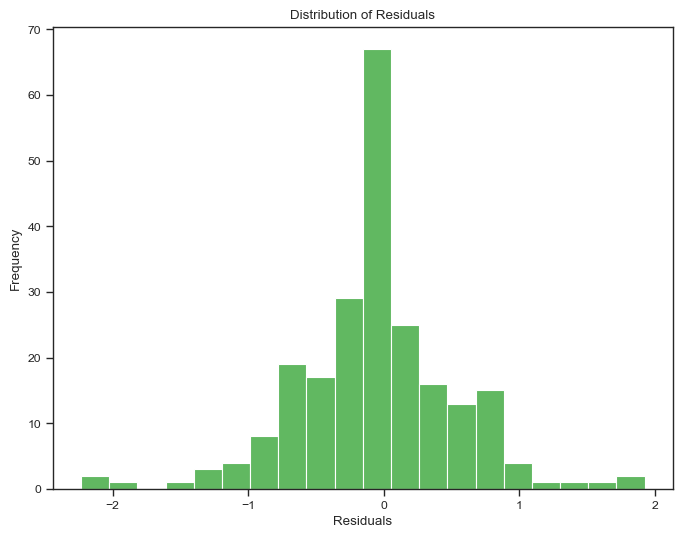

In [50]:
from sklearn.metrics import mean_squared_error

# Since you're using named steps in the pipeline, update `best_params` to work with `set_params`
best_params_updated = {key.replace(f'{best_regressor}__', '', 1): value for key, value in best_params.items()}

# Recreate the best pipeline with the best parameters
if best_regressor == 'Linear Regression':
    best_model = LinearRegression(**best_params_updated)
elif best_regressor == 'Random Forest':
    best_model = RandomForestRegressor(**best_params_updated)
elif best_regressor == 'SVR':
    best_model = SVR(**best_params_updated)
elif best_regressor == 'XGBoost':
    best_model = XGBRegressor(**best_params_updated)
elif best_regressor == 'KNeighbors':
    best_model = KNeighborsRegressor(**best_params_updated)

# Initialize the pipeline with the best model
best_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    (best_regressor, best_model)
])

# Retrain on the full training set
best_pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = best_pipeline.predict(X_test)
residuals = y_test - y_pred

# Calculate and print the MSE on the test set for evaluation
test_mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE for the best regressor ({best_regressor}): {test_mse}")

# Print summary statistics of the residuals
print("Residuals Summary Statistics:")
print(residuals.describe())

# Residual plot using seaborn and matplotlib
plt.figure(figsize=(8, 6))  # Set the figure size
sns.scatterplot(x=y_test, y=residuals, color='#2CA02C')
plt.axhline(y=0, linestyle='--', color='red')  # Adding a horizontal line at 0
plt.title('Residual Plot')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.show()


# Histogram of residuals
plt.figure(figsize=(8, 6))  # Set the figure size
sns.histplot(residuals, kde=False, color='#2CA02C', bins=20)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

## Final remarks

In this experiment, we have explored the Wine Quality Dataset from Kaggle, preprocessed the data, and evaluated different models to predict the quality of wine. We have used a pipeline to preprocess the data, and evaluated the performance of different models using hyperparameter tuning and cross-validation. We have identified the best performing model based on the negative mean squared error, and used it to make predictions on the test set. Finally, we have plotted the residuals to visually inspect the performance of the model.

This is a typical workflow in a machine learning project, where we preprocess the data, evaluate different models, and select the best performing model for making predictions. We have used a variety of models in this experiment, including Linear Regression, Random Forest Regressor, SVR, XGBoost Regressor, and KNeighbors Regressor. Each of these models has its strengths and weaknesses, and it is important to evaluate their performance on the specific dataset to identify the best model for the task at hand.